In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
path = r"/home/perdelt/benchmarks"

In [3]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties


def get_performance_single(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Goodput (requests/second)': 'sum',
        'num_errors': 'sum',
        'Latency Distribution.Average Latency (microseconds)': 'mean'
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [4]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X: center of bar
                height,                             # Y: top of bar
                f'{height:.1f}',                    # Text (1 decimal place)
                ha='center', va='bottom', fontsize=8
            )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title} by Number of Tenants and Type")
    plt.xlabel("Number of Tenants")
    plt.tight_layout()
    filename = "tpcc_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



# Container

In [5]:
codes = [
    # container
    '1750849896', #tenants=1
    '1750855816', #tenants=2
    '1750851609', #tenants=3
    '1750853501', #tenants=4
    '1750800801', #tenants=5
    '1750806919', #tenants 6
    '1750813297', #tenants=7
    '1750819742', #tenants=8
    '1750826579', #tenants=9
    '1750840810', #tenants=10
    
    # database
    '1750848184', #tenants=1
    '1750782080', #tenants=2
    '1750787463', #tenants=3
    '1750793061', #tenants=4
    '1750798872', #tenants=5
    '1750804904', #tenants=6
    '1750811177', #tenants=7
    '1750817654', #tenants=8
    '1750824366', #tenants=9
    '1750831264', #tenants=10
    
    #schema
    '1750846468', #tenants=1
    '1750780338', #tenants=2
    '1750796864', #tenants=5
    '1750785678', #tenants=3
    '1750791210', #tenants=4
    '1750802821', #tenants=6   
    '1750809059', #tenants=7
    '1750815548', #tenants=8
    '1750822119', #tenants=9
    '1750829043', #tenants=10
]

In [6]:
df_performance = get_performance_all_single(codes)
df_performance.T

connection_pod,PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-1-1-1,PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-1-2-1,PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-2-1-1,PostgreSQL-1-1-65536-1-1-1,PostgreSQL-1-1-65536-0-2-1,...,PostgreSQL-1-1-65536-2-1,PostgreSQL-1-1-65536-2-2,PostgreSQL-1-1-65536-2-3,PostgreSQL-1-1-65536-2-4,PostgreSQL-1-1-65536-2-5,PostgreSQL-1-1-65536-2-6,PostgreSQL-1-1-65536-2-7,PostgreSQL-1-1-65536-2-8,PostgreSQL-1-1-65536-2-9,PostgreSQL-1-1-65536-2-10
connection,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-1-2,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-2-1,PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-0-2,...,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2
configuration,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536-0,...,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536
experiment_run,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
client,1,2,1,1,2,2,1,1,1,2,...,2,2,2,2,2,2,2,2,2,2
pod,5t5rh.dbmsbenchmarker,v8x7q.dbmsbenchmarker,vgnbg.dbmsbenchmarker,zt8cs.dbmsbenchmarker,975q2.dbmsbenchmarker,d24hd.dbmsbenchmarker,wf55j.dbmsbenchmarker,nhr99.dbmsbenchmarker,8lnsk.dbmsbenchmarker,mbchw.dbmsbenchmarker,...,w2dv4.dbmsbenchmarker,qrl7z.dbmsbenchmarker,vqwxw.dbmsbenchmarker,snfbg.dbmsbenchmarker,zzkmq.dbmsbenchmarker,qs7rp.dbmsbenchmarker,69qbb.dbmsbenchmarker,qm42m.dbmsbenchmarker,jt7rp.dbmsbenchmarker,k2z8s.dbmsbenchmarker
pod_count,1,1,1,1,1,1,1,1,1,1,...,10,10,10,10,10,10,10,10,10,10
bench,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,...,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc
profile,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,...,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres
target,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,...,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536
time,600,600,600,600,600,600,600,600,600,600,...,600,600,600,600,600,600,600,600,600,600


In [7]:
df_multi = df_performance.set_index(['num_tenants', 'type'])
df_multi

connection           configuration  \
num_tenants type                                                          
1           container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
2           container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
3           container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
4           container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
5           container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
6           container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-5-1  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-5-2  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
7           container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-5-1  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-6-1  PostgreSQL-1-1-65536-6   
            container  PostgreSQL-1-1-65536-5-2  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-

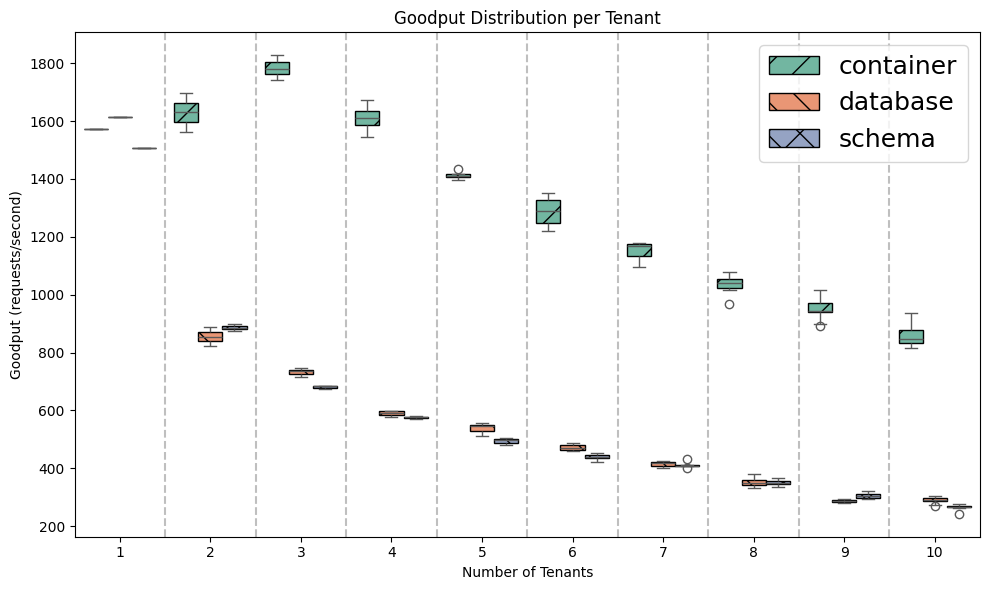

In [8]:
df = df_performance[df_performance['client']=='1']
#df = df_performance.copy()

plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Goodput (requests/second)',
    hue='type',
    palette='Set2'  # consistent colors per type
)
# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

plt.title("Goodput Distribution per Tenant")
plt.xlabel("Number of Tenants")
plt.ylabel("Goodput (requests/second)")
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
plt.show()

In [9]:
df_performance = get_performance_all(codes)
df_performance

,client,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),type,num_tenants
0,1,1573.971516,6,62914.000000,container,1
1,2,3752.529821,43,26257.000000,container,1
0,1,3259.649810,30,60789.500000,container,2
1,2,6690.324652,97,29462.000000,container,2
0,1,5349.228066,71,55429.000000,container,3
1,2,8393.221526,136,35217.333333,container,3
0,1,6434.534533,84,61425.000000,container,4
1,2,9456.329515,180,41651.750000,container,4
0,1,7067.734660,86,69814.400000,container,5
1,2,9906.644639,164,49688.200000,container,5


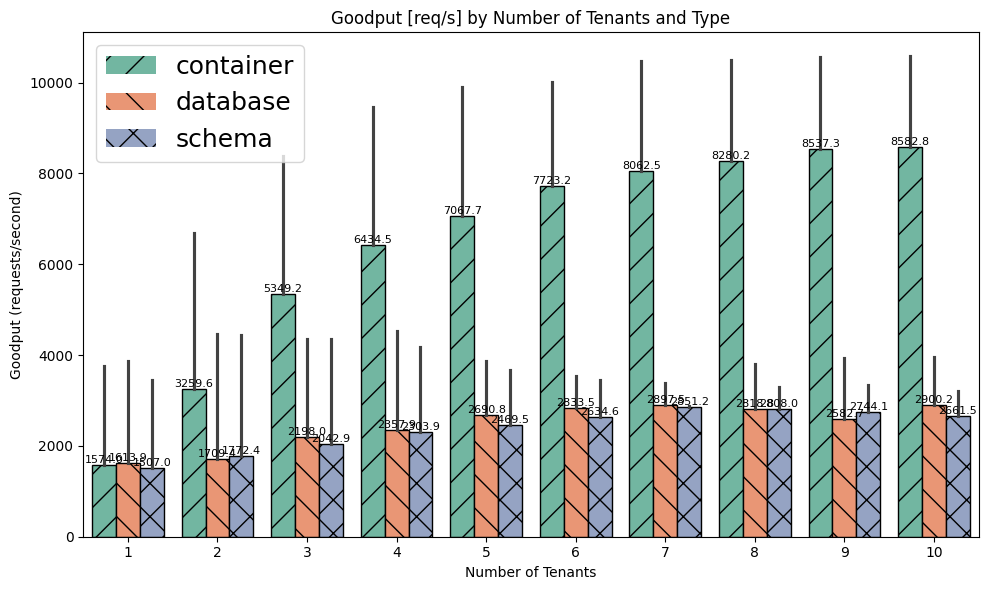

In [10]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='min')

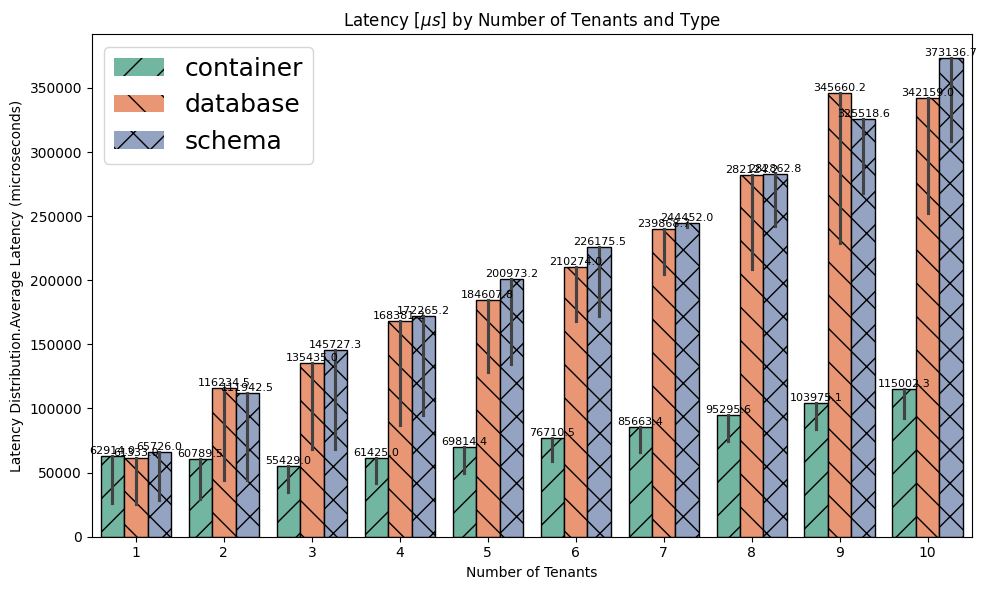

In [11]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='max')

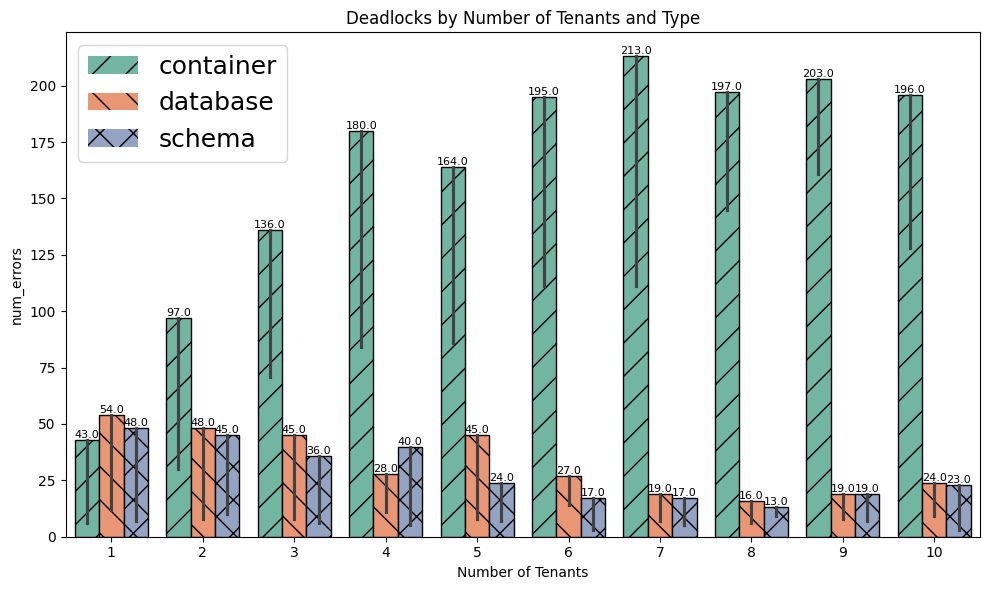

In [12]:
plot_bars(df_performance, y='num_errors', title='Deadlocks', estimator='max')

In [13]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-1-1-65536-0-1,261.0,104.0,157.0,1,1,0,1,2720,container,1
PostgreSQL-1-1-65536-0-2,261.0,104.0,157.0,1,1,0,2,6264,container,1
PostgreSQL-1-1-65536-0-1,324.0,136.0,188.0,1,1,0,1,2720,container,2
PostgreSQL-1-1-65536-0-2,324.0,136.0,188.0,1,1,0,2,6284,container,2
PostgreSQL-1-1-65536-1-1,302.0,115.0,187.0,1,1,1,1,2720,container,2
PostgreSQL-1-1-65536-1-2,302.0,115.0,187.0,1,1,1,2,6518,container,2
PostgreSQL-1-1-65536-0-1,265.0,104.0,161.0,1,1,0,1,2720,container,3
PostgreSQL-1-1-65536-0-2,265.0,104.0,161.0,1,1,0,2,6782,container,3
PostgreSQL-1-1-65536-1-1,279.0,118.0,161.0,1,1,1,1,2720,container,3
PostgreSQL-1-1-65536-1-2,279.0,118.0,161.0,1,1,1,2,6598,container,3


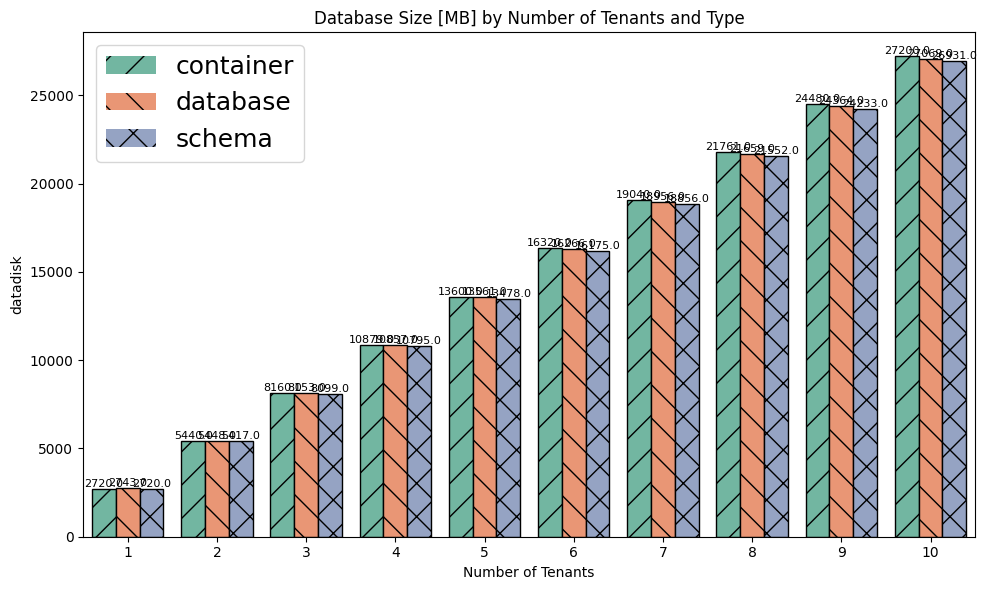

In [14]:
df_performance_first = df_performance[df_performance['client'] == '1']
plot_bars(df_performance_first, y='datadisk', title='Database Size [MB]', estimator='sum')

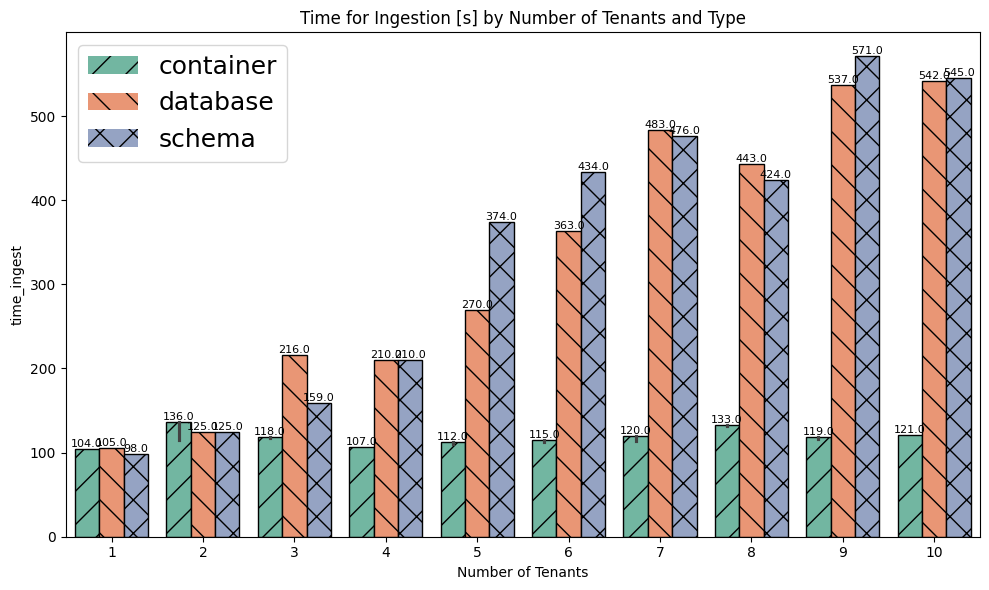

In [15]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

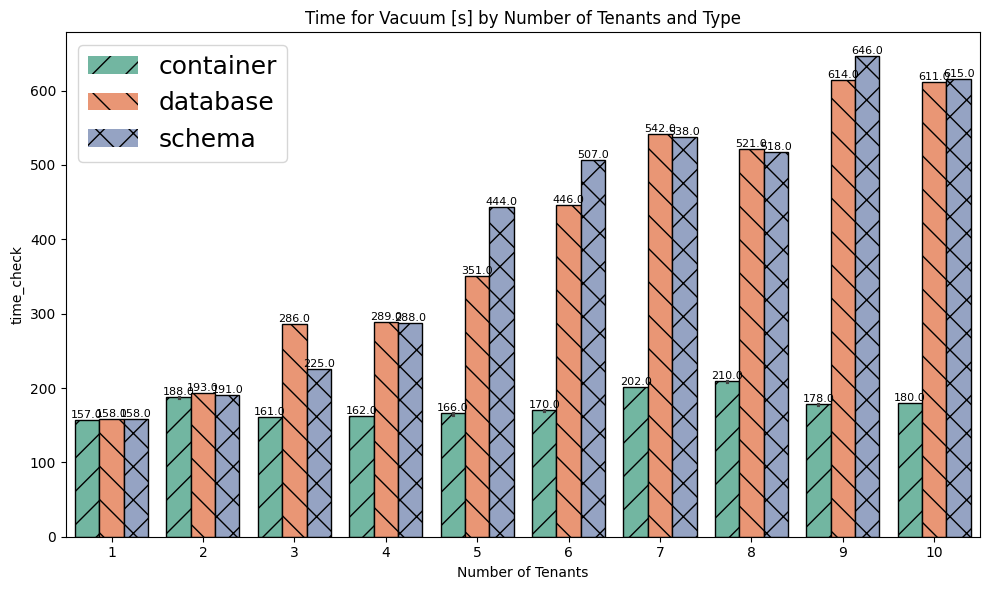

In [16]:
plot_bars(df_performance, y='time_check', title='Time for Vacuum [s]', estimator='max')

In [17]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,7969.80,5.19,7.08,18.47,container,1
0,1,18572.93,10.42,14.25,35.22,container,2
0,1,28905.17,15.78,21.64,49.34,container,3
0,1,31604.34,20.52,27.90,54.83,container,4
0,1,33848.08,25.17,34.00,57.49,container,5
0,1,34559.77,29.63,39.73,59.26,container,6
0,1,35471.47,34.00,45.34,59.88,container,7
0,1,35044.63,38.57,51.28,59.57,container,8
0,1,35036.49,42.70,56.42,59.30,container,9
0,1,36293.30,46.96,61.79,60.94,container,10


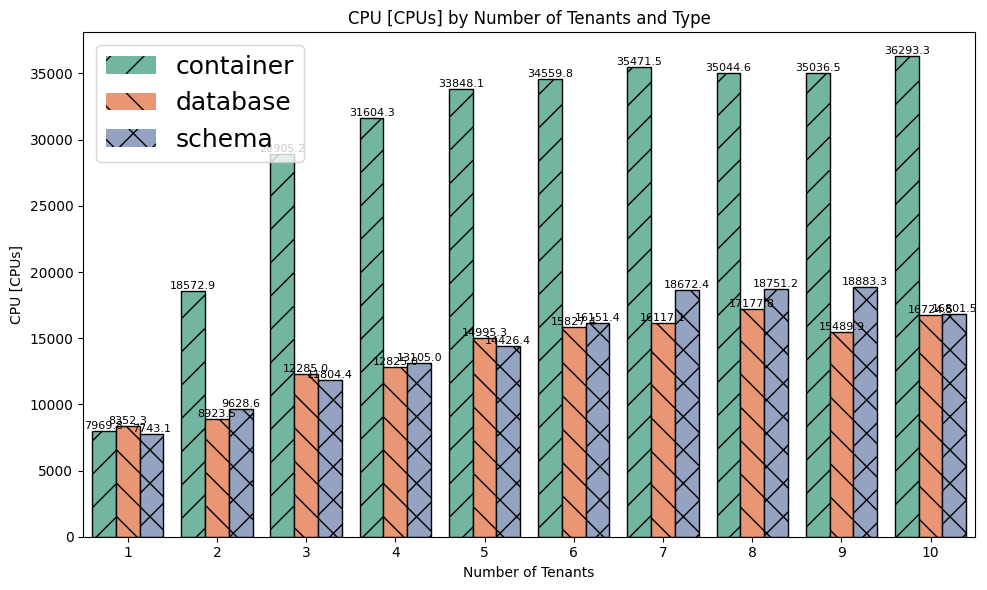

In [18]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

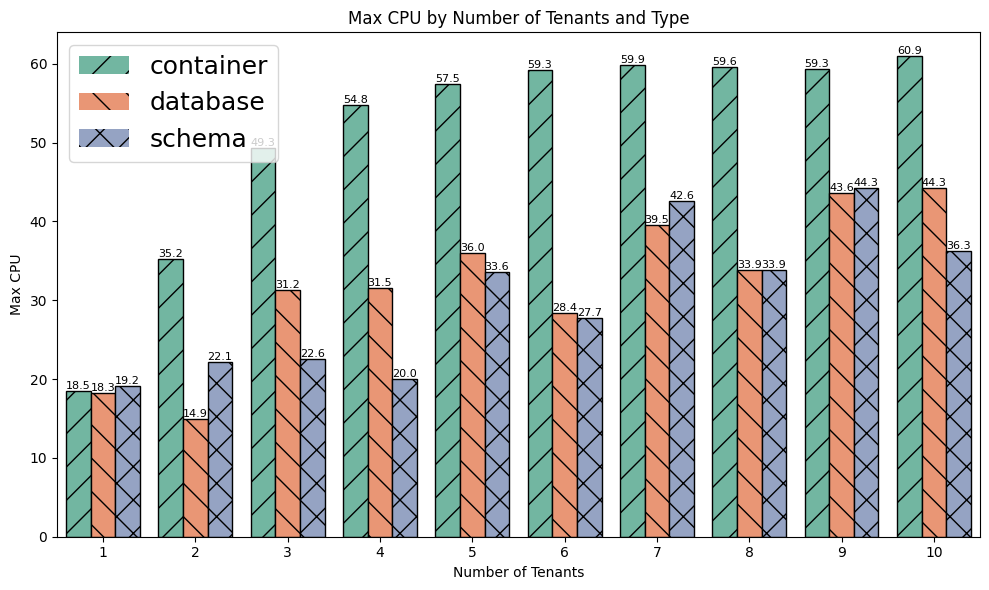

In [19]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

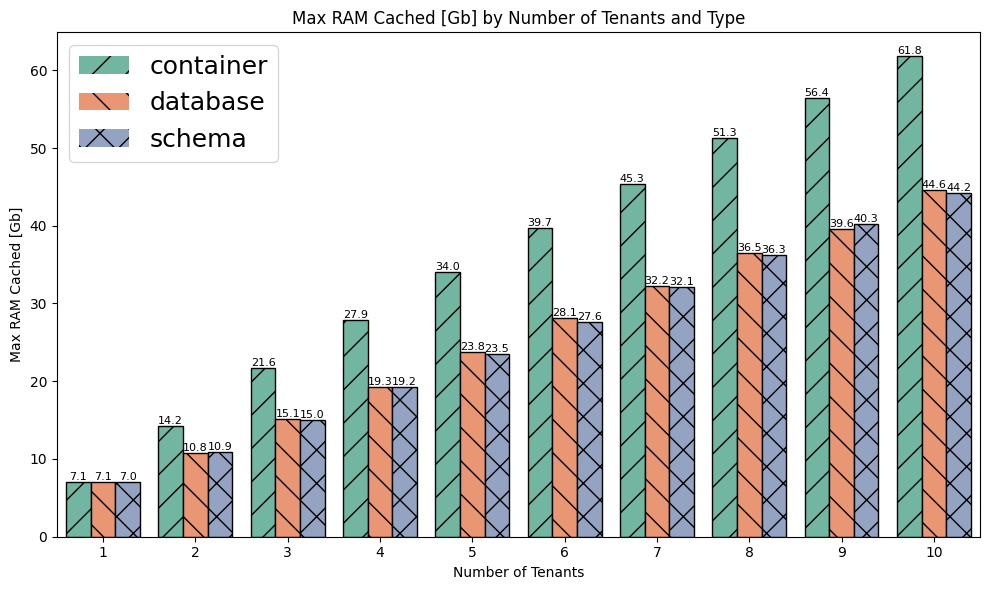

In [20]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

# Single Experiment

In [21]:
code = '1750741356'
evaluation = evaluators.benchbase(code=code, path=path)
workload = get_workload(code)

In [22]:
df=get_performance_single(evaluation)
df['type']=workload['tenant_per']
df['num_tenants']=workload['num_tenants']
df.T

connection_pod,PostgreSQL-1-1-16384-1-1,PostgreSQL-1-1-16384-1-2,PostgreSQL-1-1-16384-1-3,PostgreSQL-1-1-16384-1-4,PostgreSQL-1-1-16384-1-5,PostgreSQL-1-1-16384-1-6,PostgreSQL-1-1-16384-1-7,PostgreSQL-1-1-16384-1-8,PostgreSQL-1-1-16384-1-9,PostgreSQL-1-1-16384-2-1,PostgreSQL-1-1-16384-2-2,PostgreSQL-1-1-16384-2-3,PostgreSQL-1-1-16384-2-4,PostgreSQL-1-1-16384-2-5,PostgreSQL-1-1-16384-2-6,PostgreSQL-1-1-16384-2-7,PostgreSQL-1-1-16384-2-8,PostgreSQL-1-1-16384-2-9
connection,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2
configuration,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384
experiment_run,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
client,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2
pod,v8pgd.dbmsbenchmarker,bzrfv.dbmsbenchmarker,tqj89.dbmsbenchmarker,sk5cz.dbmsbenchmarker,5whq6.dbmsbenchmarker,h4z87.dbmsbenchmarker,9l5dp.dbmsbenchmarker,tdpzd.dbmsbenchmarker,jrbdr.dbmsbenchmarker,pwlbg.dbmsbenchmarker,f9gzm.dbmsbenchmarker,zkgfb.dbmsbenchmarker,nz6tc.dbmsbenchmarker,8c249.dbmsbenchmarker,n6x9k.dbmsbenchmarker,s6j9t.dbmsbenchmarker,gq2mn.dbmsbenchmarker,xbjz6.dbmsbenchmarker
pod_count,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
bench,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc
profile,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres
target,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384
time,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600


In [23]:
get_loading_time_max(evaluation)

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk
PostgreSQL-1-1-16384-1,1149.0,526.0,615.0,1,9,,1,24232
PostgreSQL-1-1-16384-2,1149.0,526.0,615.0,1,9,,2,36837


In [24]:
get_monitoring_stream_single(evaluation).sort_values('client')

,CPU [CPUs],Max CPU,Max RAM [Gb],Max RAM Cached [Gb],client
PostgreSQL-1-1-16384-1,19066.36,41.08,29.02,40.21,1
PostgreSQL-1-1-16384-2,23623.90,50.35,32.22,45.44,2


In [25]:
get_monitoring_stream(evaluation)

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU
0,1,19066.36,29.02,40.21,41.08
1,2,23623.90,32.22,45.44,50.35
